<a href="https://colab.research.google.com/github/thecrazyphysicist369/strategic-Covid19-testing/blob/main/v2_Random_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Random Testing

#Run this cell


In [1]:
#Importing all the necessary libraries
import matplotlib.pyplot as plt
import networkx as nx
import random
import numpy as np
import time
import math
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import pandas as pd

This is the new model which considers the amount and the order of infection. This also considers the parameters and virus spreading more like real world. The *Contamination Level* for each individual is the amount of virus they are exposed to.

1. 1 < *Cont_level* < 25 : Susceptible
2. 26 < *Cont_level* < 50 : Exposed
3. 51 < *Cont_level* < 75 : Infected
4. 76 < *Cont_level* : Recovered

#Run this cell

In [2]:
#vertex generator generates each individual with their properties
def gen_vertex(n):
    ver_list=[]
    c=0

    for i in range(n):
      vertex = {
                'index': c, 			# the unique index of the voter
                'cont_level' : 0, # a positive number that increases everytime the
                                  #individual meets another with covid.
                'connected' : [], # the small world connections between the individuals
                'd_sus' : 0,      # number of days the individual is susceptible
                'd_expo' : 0,     # number of days the individual is exposed
                'd_inf' : 0,      # number of days the individual is infected
                'd_reco' : 0,      # number of days the individual takes to recover
                'd_test' : 0,     
                'd_death' : 0
                }
      ver_list.append(vertex)
      c+=1
    return ver_list

#Generating the Small World Network
def gen_graph(n, k, p):
   population = gen_vertex(n)
   G = nx.watts_strogatz_graph(n, k, p, seed=10)
   neighbor = []
   for node in list(sorted(G.nodes())):
   	neighbours = list(nx.all_neighbors(G, node))
   	neighbor.append(neighbours)
   for i in range(n):
     population[i]['connected'] = neighbor[i]
     population[i]['index'] = int(i)
     population[i]['cont_level'] = random.randint(0, 15)
   return population

#this is to expose n individuals from the population to the virus
#1/5th of the exposed individuals will be infected in random
def expose_population(n, population):
  inf_list = []
  limit = len(population)-1
  for i in range(n):
    index = random.randint(0, limit)
    inf_list.append(index)
    population[index]['cont_level'] = random.randint(25, 30) 
  return population, inf_list

#random testing
def random_testing(pop, tpm): #pop = population; tpm = tests per million
  numbers = len(pop) # total population
  test = int((tpm * numbers)/1000000) # number of tests that is needed to be done
  for i in range(test): 
    index = random.randint(0, numbers - 1)
    if pop[index]['cont_level'] <= 150 and pop[index]['cont_level'] > 25:
      pop[index]['cont_level'] = -10
  return pop

#Death function
def death(pop, infected):
  for i in range(random.randint(0, int(len(infected)/100))):
    index = infected[i]
    pop[index]['cont_level']=151
  return pop

#Recovery
def recovery(pop, infected):
  for i in range(random.randint(0, int(len(infected)/10))):
    index = infected[i]
    pop[index]['cont_level']=-10
  return pop



#Contamination function
def contaminate(a, b):
  if a > 0 and a <= 130:
    new = a + math.log10(b)
  else:
    new = a
  return new

def progress_bar(est, elas):
  perc=(elas/est)*10
  perc=int(perc)
  rem=10-perc
  print('[','#'*perc,' '*rem,']', ' ',perc*10, '%')

#Run this cell

In [3]:
def days(pop, tpm):
  list_S = [] #list for Susceptible Individuals
  list_E = [] #list for Exposed Individuals
  list_I = [] #list for Infected Individuals
  list_R = [] #list for Recovered Individuals
  list_D = [] #list for Dead Individuals

  #Adding person to the respective lists based on their status
  #compartmening the population

  #Also creating a distribution map of the people
  for person in pop:
    level = person['cont_level']
    if level >= 0 and level <= 25:
      list_S.append(person['index'])
      person['d_sus'] +=1
    elif level > 25 and level <= 65:
      list_E.append(person['index'])
      person['d_expo'] +=1
    elif level > 65 and level <=150:
      list_I.append(person['index'])
      person['d_inf'] +=1
    elif level > 150:
      list_D.append(person['index'])
      person['d_death'] += 1
    elif level==-10:
      list_R.append(person['index'])
      #person['d_reco'] = random.randint(0,15)
      person['d_reco'] += 1



  #Infecting 1/5th of exposed population
  ex_num = len(list_E)
  num = int(ex_num/5)
  for i in range(num):
    r = random.randint(0,ex_num-1)
    list_I.append(list_E[r])
    list_E.pop(r)
    ex_num = len(list_E)


  #Spreading the Virus
  for i in list_I:
    friends = pop[i]['connected']  
    for contacts in friends:
      A = pop[contacts]['cont_level'] #is consuming
      B = pop[i]['cont_level'] #is spreading
      pop[contacts]['cont_level'] = contaminate(A, B)  #write a good fucntion here

  

  #Removing the duplicates from the list
  list_S = list(dict.fromkeys(list_S))
  list_E = list(dict.fromkeys(list_E))
  list_I = list(dict.fromkeys(list_I))
  list_R = list(dict.fromkeys(list_R))
  list_D = list(dict.fromkeys(list_D))

  #testing the population
  pop = random_testing(pop, tpm)
  pop = recovery(pop, list_I)
  pop = death(pop, list_I)


  return (pop, list_S, list_E, list_I, list_R, list_D)

#Execute this if you want to run the simulation with input values.

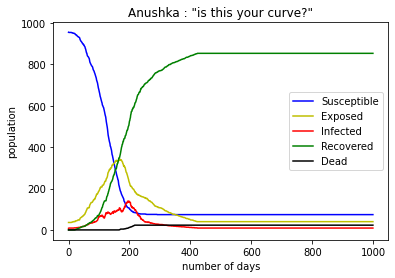

In [7]:

population_size = 1000 #int(input("Enter population size : "))

k = 5 # int(input("\nk nearest neighbors : "))

p = 0.5 # float(input("\nProbablity of the contacts : "))

tpm = 200 #int(input("\nTests per million population : "))

iterations = 1000 #int(input("\nNumber of days the model to run : "))

ex = 50 #int(input("\nNumber of Individuals initially exposed"))


#Generating the small world network
population = gen_graph( population_size, k, p)

#Exposing the population
#li is the list of the first round of exposed population
population,li = expose_population(ex, population)


#Number of days the simulation need to run
count = np.arange(iterations)


# List to contain the current data
susp = []
expo = []
infe = []
reco = []
dead = []


elapsed = 0
# Running the days simulation for given number of days
for j in range (iterations):
	inter = []
	tic = time.time()
	population, sus, exp, inf, rec, ded = days(population, tpm)
	susp.append(len(sus)) #Count of suspected persons per day
	expo.append(len(exp)) #Count of exposed persons per day
	infe.append(len(inf)) #Count of infected persons per day
	reco.append(len(rec)) #Count of recovered persons per day
	dead.append(len(ded))
	toc = time.time()
	one_day = toc - tic
	elapsed += one_day  
	estimated = elapsed*(iterations-j)
	remaining = (iterations * one_day) - (j * one_day)
	#progress_bar(estimated, elapsed)
	#print("Doing ",j,"th iteration. Time :","{:.2f}".format(one_day),
	#      "secs. Elapsed time :","{:.2f}".format(elapsed),"secs. Estimated : ","{:.2f}".format(estimated),"secs")


plt.plot(count, susp, color='b', label = "Susceptible")
plt.plot(count, expo, color='y', label = "Exposed")
plt.plot(count, infe, color='r', label = "Infected")
plt.plot(count, reco, color='g', label = "Recovered")
plt.xlabel('number of days')
plt.ylabel('population')
plt.plot(count, dead, color='k', label = "Dead")
label = "Probability = "+str(p)+". Nearest Neigbours = "+str(k)+"."
plt.title(label, fontdict=None, loc='center', pad=None)
plt.legend()
plt.show()


##Save the output in a csv

In [13]:
#Saving the comparmental values
comp_frame = np.array([susp, expo, infe, reco, dead])
comp_dataset = pd.DataFrame(comp_frame).T
comp_dataset.columns = ["Susceptible","Exposed","Infected","Recovered","Dead"]
comp_dataset.to_csv("compartmental.csv")
int_pop_index = [] #[int(item) for item in population['index']]
for item in population['index']:
  int_pop_index.append(int(item))
#Saving the population values
pop_frame = np.array([int_pop_index,
                      int(population['cont_level']),
                      int(population['connected']),
                      int(population['d_sus']),
                      int(population['d_expo']),
                      int(population['d_inf']),
                      int(population['d_reco']),
                      int(population['d_death'])])
pop_dataset = pd.DataFrame(pop_frame).T
pop_dataset.columns = ['Index', 
                       'Contamination Level',
                       'Nearest Neighbors',
                       'Days since Susceptible',
                       'Days since Exposed',
                       'Days since Infected',
                       'Days since Recovered',
                       'Days since Death']
pop_dataset.to_csv('population.csv')

TypeError: ignored

##Distribution of the compartments

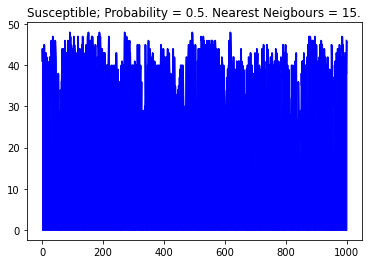

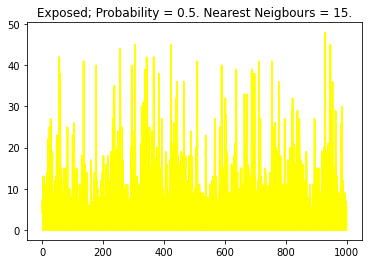

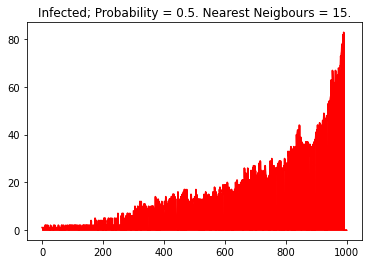

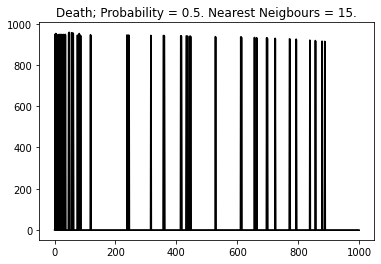

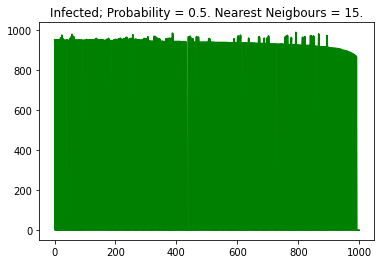

In [ ]:
#data saver
#tbd plot death and recovery
d_sus, d_expo, d_inf, d_death, d_reco=[], [], [], [], []
for person in population:
  d_expo.append(person['d_expo'])
  d_reco.append(person['d_reco'])
  d_death.append(person['d_death'])
  #d_sus.append(person['d_sus'])
  if person['d_inf'] > 100:
    d_inf.append(0)
  else : 
    d_inf.append(person['d_inf'])
  if person['d_sus'] == 1000:
    d_sus.append(40)
  else :
    d_sus.append(person['d_sus'])


pop_len = []
for i in len(population):
  pop_len.append(i)


#Plotting the susceptible distribution
sus_plt = plt.plot(count, d_sus, color = 'b')
sus_plt = plt.fill_between(count, d_sus, color = 'b')
label = "Susceptible; Probability = "+str(p)+". Nearest Neigbours = "+str(k)+"."
sus_plt = plt.title(label, fontdict=None, loc='center', pad=None)
sus_plt = plt.savefig('susceptible distribution.png')
sus_plt = plt.show()
#Plotting the exposed distribution
expo_plt = plt.plot(count, d_expo, color = '#ffff00')
expo_plt = plt.fill_between(count, d_expo, color = '#ffff00')
label = "Exposed; Probability = "+str(p)+". Nearest Neigbours = "+str(k)+"."
expo_plt = plt.title(label, fontdict=None, loc='center', pad=None)
expo_plt = plt.show()
#plotting the infected distribution
inf_plt = plt.plot(count, d_inf, color = 'r')
inf_plt = plt.fill_between(count, d_inf, color = 'r')
label = "Infected; Probability = "+str(p)+". Nearest Neigbours = "+str(k)+"."
inf_plt = plt.title(label, fontdict=None, loc='center', pad=None)
inf_plt = plt.show()
#plotting the death distribution
inf_plt = plt.plot(count, d_death, color = 'k')
inf_plt = plt.fill_between(count, d_death, color = 'k')
label = "Death; Probability = "+str(p)+". Nearest Neigbours = "+str(k)+"."
inf_plt = plt.title(label, fontdict=None, loc='center', pad=None)
inf_plt = plt.show()
#plotting the recovered distribution
inf_plt = plt.plot(count, d_reco, color = 'g')
inf_plt = plt.fill_between(count, d_reco, color = 'g')
label = "Infected; Probability = "+str(p)+". Nearest Neigbours = "+str(k)+"."
inf_plt = plt.title(label, fontdict=None, loc='center', pad=None)
inf_plt = plt.show()



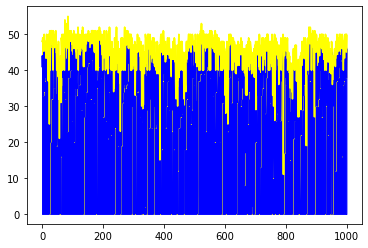

In [ ]:
#complete this part
cd_expo, cd_inf, cd_reco, cd_death  = []
for i in range(len(population)):
  cd_expo.append(d_sus[i]+d_expo[i])

#Combined Plot
plt.plot(count, d_sus, color = 'b')
plt.fill_between(count, d_sus, color = 'b' )
plt.plot(count, cd_expo, color = '#ffff00')
plt.fill_between(count, cd_expo, d_sus, color = '#ffff00')
plt.plot
plt.show()

##For iterative execution of more than one variable set

In [ ]:
#automate the entire process here


#Execute this if you want to run the simulation with sliders.

In [ ]:
pop = widgets.IntSlider(value=5000, 
                      description='population size', 
                      max=100000, 
                      min=10000,
                      step=10000) #population_size
k = widgets.IntSlider(value=10, 
                      description='nearest neighbors', 
                      max=100, 
                      min=0,
                      step=5) #nearest neighbor
p = widgets.FloatSlider(value=0.5,
                        description='probability', 
                        max=1, 
                        min=0, 
                        step=0.1) #probability
iter = widgets.IntSlider(value=100, 
                               description='days', 
                               max=600, 
                               min=0, 
                               step=20)
tpm = widgets.IntSlider(value=1000,
                        description='test per million',
                        max=100000,
                        min=1000,
                        step=1000)
ex = widgets.IntSlider(value=50,
                       description='initial exposed',
                       max=500,
                       min=10,
                       step=10)


def simulation(pop,k,p,iter,tpm,ex):
    #Generating the small world network
    population = gen_graph(pop, k, p)

    #Exposing the population
    #li is the list of the first round of exposed population
    population,li = expose_population(ex, population)


    #Number of days the simulation need to run
    count = np.arange(iter)


    # List to contain the current data
    susp = []
    expo = []
    infe = []
    reco = []
    dead = []


    elapsed = 0
    # Running the days simulation for given number of days
    for j in range (iter):
      inter = []
      tic = time.time()
      population, sus, exp, inf, rec, ded = days(population, tpm)
      susp.append(len(sus)) #Count of suspected persons per day
      expo.append(len(exp)) #Count of exposed persons per day
      infe.append(len(inf)) #Count of infected persons per day
      reco.append(len(rec)) #Count of recovered persons per day
      dead.append(len(ded))
      toc = time.time()
      one_day = toc - tic
      elapsed += one_day
      estimated = elapsed*(iter-j)
      remaining = (iter * one_day) - (j * one_day)
      #print("Doing ",j,"th iteration. Time :","{:.2f}".format(one_day),
       #     "secs. Elapsed time :","{:.2f}".format(elapsed),"secs. Remaining : ","{:.2f}".format(remaining),"secs")
    #progress_bar(estimated,elapsed)
    
    plt.figure(figsize=(20,10))
    plt.plot(count, susp, color='b', label = "Susceptible")
    plt.plot(count, expo, color='y', label = "Exposed")
    plt.plot(count, infe, color='r', label = "Infected")
    plt.plot(count, reco, color='g', label = "Recovered")
    plt.plot(count, dead, color='k', label = "Dead")
    label = "Probability = "+str(p)+". Nearest Neigbours = "+str(k)+"."
    plt.title(label, fontdict=None, loc='center', pad=None)
    plt.legend()
    return()
ui = widgets.HBox([pop,k,p,iter,tpm,ex])
out = widgets.interactive_output(simulation, {'pop':pop,'k':k,'p':p,'iter':iter,'tpm':tpm,'ex':ex})

display(ui, out)

Output()